In [97]:
#!pip install validators
#!pip install torch torchvision torchaudio
#!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
#%pip install torchinfo

In [98]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd
import gc
import traceback
import random
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [99]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [100]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [101]:
DATADIR = "BeeMachine_quarter"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [102]:
def load_dataset(is_simple_transform=True):
    if is_simple_transform:
        transformer = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])
    else:
        transformer = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
                                    std=[0.2403, 0.2280, 0.2248])
        ])
    
    #Load image
    dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
    return dataset


In [103]:
def find_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages

    print(mean)
    print(std)

#find_mean_std(bee_dataset)
# mean tensor([0.4904, 0.4515, 0.3639])
# std tensor([0.2403, 0.2280, 0.2248])


Separate data to train and validation dataset

In [104]:
bee_dataset = load_dataset(is_simple_transform=False)

num_classes=len(bee_dataset.targets)
train_indices, val_indices = train_test_split(list(range(num_classes)), test_size=0.2, stratify=bee_dataset.targets)
train_dataset = torch.utils.data.Subset(bee_dataset, train_indices)
val_dataset = torch.utils.data.Subset(bee_dataset, val_indices)
resnet50.fc = nn.Sequential(
               nn.Linear(2048, 224),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(224, 45),
               nn.Softmax()).to(device) 
torch.autograd.set_detect_anomaly(True)               

Create DataLoader

In [105]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
print(torch.cuda.memory_allocated(device))
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print(torch.cuda.memory_allocated(device))

557749248
557749248


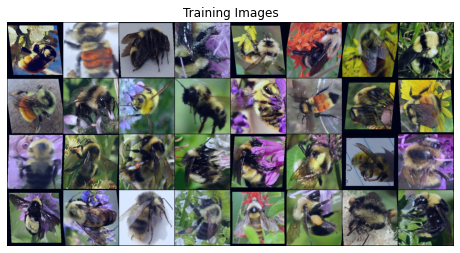

In [106]:
# Plot some training images
real_batch = next(iter(train_data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [107]:
weights = class_weight.compute_class_weight('balanced', np.unique(bee_dataset.targets), bee_dataset.targets)
class_weights=torch.tensor(np.unique(bee_dataset.targets),dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=beta1)


In [ ]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)

def train_model(model, dataloaders, criterion, optimizer, train_loss, train_acc, total_step, num_epochs=3):
    for epoch in range(1, num_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        model.train()
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(dataloaders):
            data_, target_ = data_.to(device), target_.to(device)            
            outputs = model(data_)
            loss = criterion(outputs, target_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            #print("matrix predict {} target {}".format(pred, target_))
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, num_epochs, batch_idx * batch_size, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        
        validate_model(model_trained, val_data_loader, valid_loss_min, val_loss, val_acc)
                  
    return model



In [109]:
def validate_model(model, dataloaders, valid_loss_min, val_loss, val_acc):
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_, target_ in dataloaders:
            data_t, target_t = data_.to(device), target_.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            #print("predict {} target {}".format(len(pred_t), len(target_t)))
            #print("matrix predict {} target {}".format(pred_t, target_t))
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(dataloaders))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        if network_learned:
            modelPath = 'models/pytorch'
            isExist = os.path.exists(modelPath)
            if not isExist:
                # Create a new directory because it does not exist 
                os.makedirs(modelPath)
                print("The new directory {} is created!".format(modelPath))
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'models/pytorch/traiend_resnet50.h5')
            print('Improvement-Detected, save-model')

In [110]:
def show_confusion_matrix(model, labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [111]:
try:
    model_trained = train_model(resnet50, train_data_loader, criterion, optimizer, train_loss, train_acc, total_step, num_epochs)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Epoch 1

Epoch [1/1], Step [0/31848], Loss: 3.8059
Epoch [1/1], Step [640/31848], Loss: 3.8069
Epoch [1/1], Step [1280/31848], Loss: 3.8067
Epoch [1/1], Step [1920/31848], Loss: 3.8058
Epoch [1/1], Step [2560/31848], Loss: 3.8066
Epoch [1/1], Step [3200/31848], Loss: 3.8063


Save Model

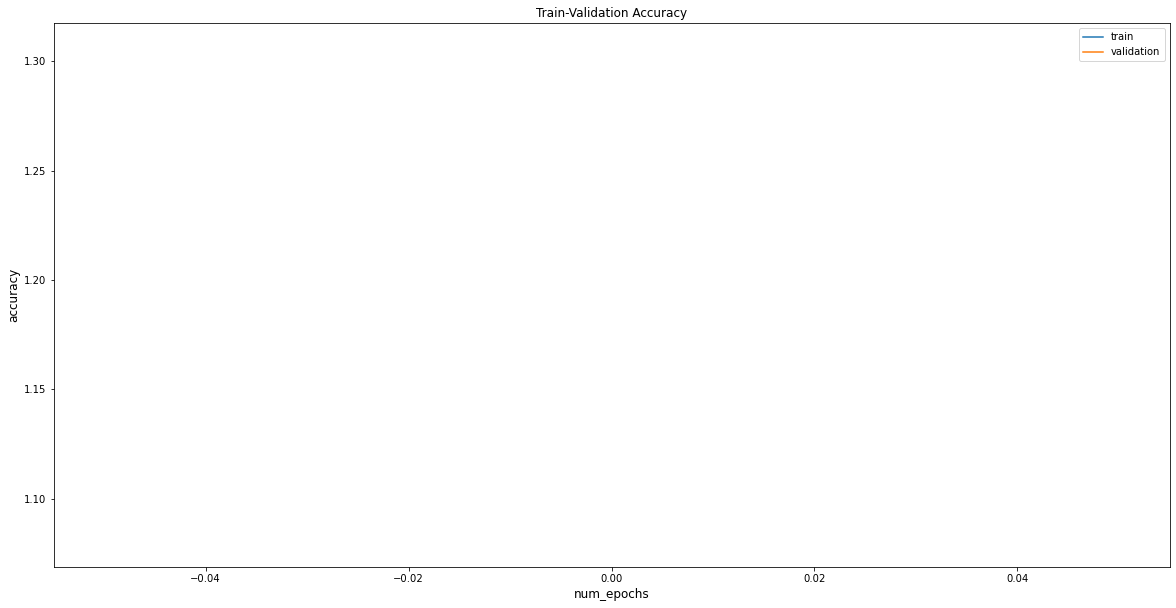

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
#resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
#resnet50.load_state_dict(torch.load('models/pytorch/traiend_resnet50.h5'))                 

## DCGAM

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

def train_DCGAN(dataloader):

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, (data, label) in enumerate(dataloader):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), 1., dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
            errD = errD_real
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(1.)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(real_cpu).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\t'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x))

            # Save Losses for plotting later
            G_losses.append(errG.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

In [ ]:
#train_DCGAN(train_data_loader)

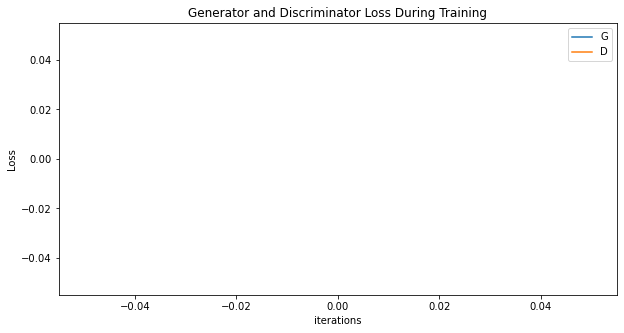

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



## OVER SAMPLEING ## 


TEST Github+
TRY +1


## Yelei Test